# 🎯 Customer Churn Prediction & Retention System

**Dataset:** Telco Customer Churn (Kaggle)  
**Objective:** Predict customer churn using Random Forest and provide actionable business insights  
**Model Performance:** 79% accuracy, 73% precision in top risk decile

---

## 1. Environment Setup & Data Loading

In [1]:
# ===== Import All Required Libraries =====
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ===== Create Output Directory =====
os.makedirs('images', exist_ok=True)
print("✅ Output directory 'images/' ready")

# ===== Load Dataset =====
# Note: Adjust path if running locally (remove '/content/' for local execution)
try:
    data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
except FileNotFoundError:
    data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f"✅ Data loaded: {data.shape[0]} customers, {data.shape[1]} features")

# ===== Create SQLite Database =====
conn = sqlite3.connect('telecom_churn.db')
data.to_sql('customers', conn, if_exists='replace', index=False)
print("✅ SQL database created and data loaded")

✅ Output directory 'images/' ready
✅ Data loaded: 7043 customers, 21 features
✅ SQL database created and data loaded


## 2. Data Profiling & Cleaning

In [2]:
# ===== Initial Data Inspection =====
print("📊 Dataset Overview:")
print(data.info())
print(f"\n🔍 Duplicate rows: {data.duplicated().sum()}")
print(f"🔍 Duplicate Customer IDs: {data['customerID'].duplicated().sum()}")

# ===== Identify Hidden Missing Values =====
# Replace empty strings with NaN to expose hidden missing values
temp_df = data.replace(' ', np.nan)

# Check for missing values
missing_values = temp_df.isnull().sum()
print(f"\n⚠️ Hidden missing values found:")
print(missing_values[missing_values > 0])

# ===== Fix TotalCharges Data Type =====
temp_df['TotalCharges'] = pd.to_numeric(temp_df['TotalCharges'], errors='coerce')

# ===== Business Logic Decision =====
# Missing TotalCharges are all from new customers (tenure <= 1)
# They haven't been billed yet, so we fill with 0
data = temp_df.fillna({'TotalCharges': 0})

# ===== Update SQL Database =====
data.to_sql('customers', conn, if_exists='replace', index=False)
print("\n✅ Data cleaned and SQL database updated")

📊 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

## 3. Business Metrics Analysis

In [3]:
# ===== Calculate Key Business Metrics via SQL =====
business_query = """
SELECT
    ROUND(AVG(MonthlyCharges), 2) as ARPU,
    ROUND((SELECT SUM(MonthlyCharges) / COUNT(*) FROM customers WHERE Churn = 'Yes'), 2) as Churn_ARPU,
    ROUND((SELECT COUNT(*) FROM customers WHERE Churn = 'Yes') * 100.0 / COUNT(*), 2) as Churn_Rate_Percent,
    ROUND((SELECT SUM(MonthlyCharges) FROM customers WHERE Churn = 'Yes'), 2) as Monthly_Revenue_Loss
FROM customers
"""

metrics_df = pd.read_sql_query(business_query, conn)
print("💼 Business Metrics Summary:")
print(metrics_df)

# Key Insight: Churn_ARPU > ARPU indicates we're losing higher-value customers

💼 Business Metrics Summary:
    ARPU  Churn_ARPU  Churn_Rate_Percent  Monthly_Revenue_Loss
0  64.76       74.44               26.54             139130.85


## 4. Exploratory Data Analysis (EDA)
Generating visualizations to understand churn patterns

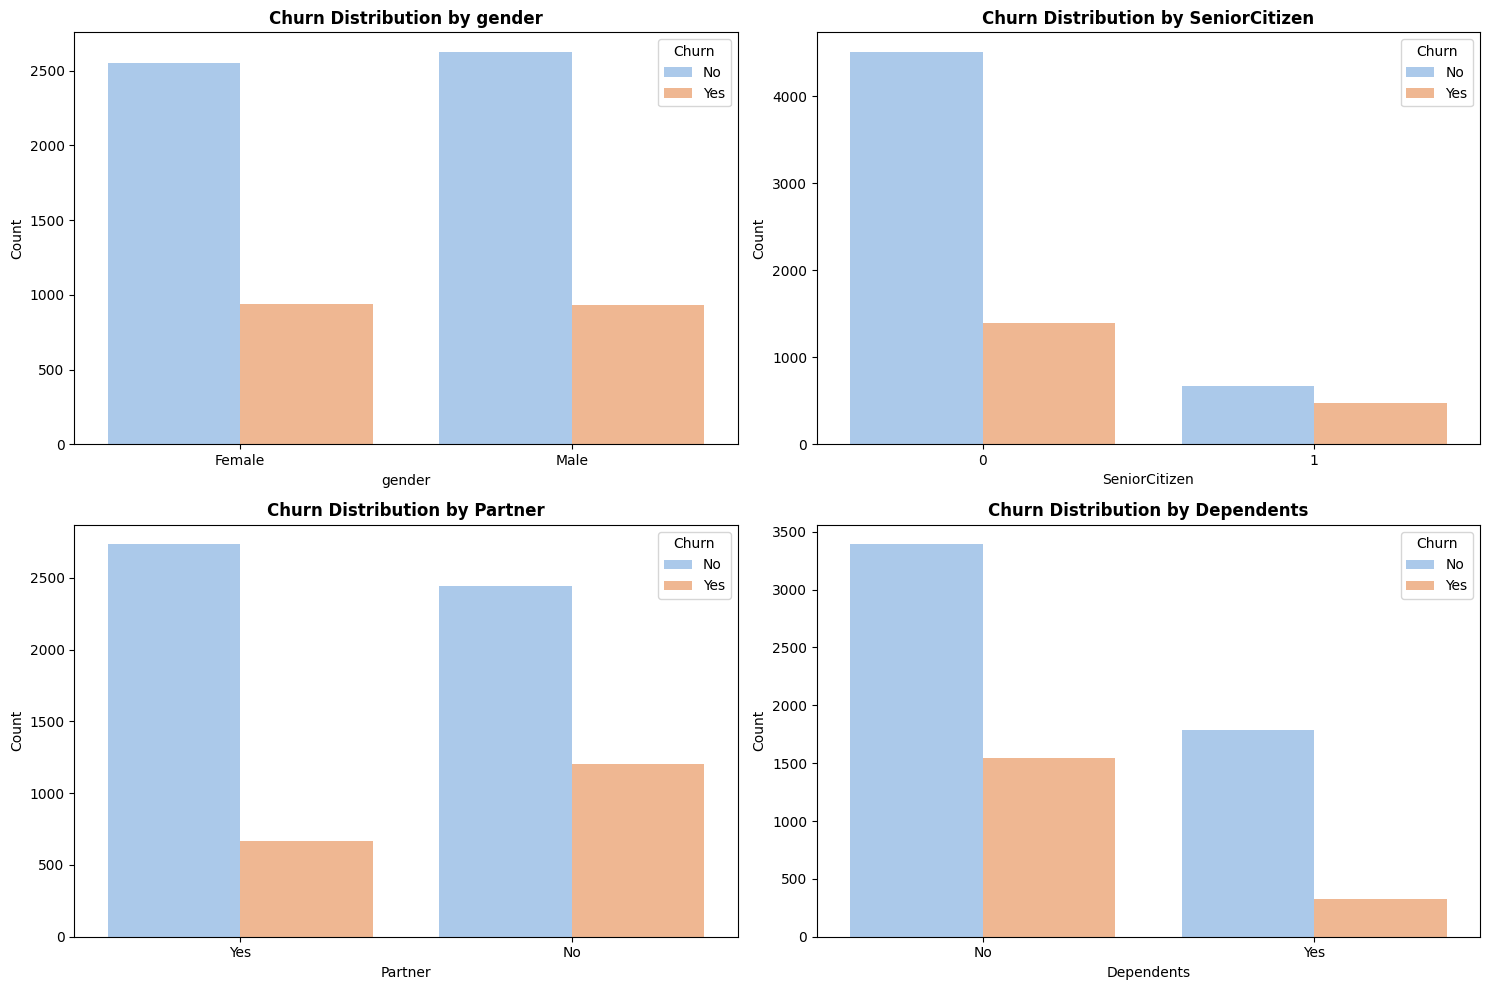

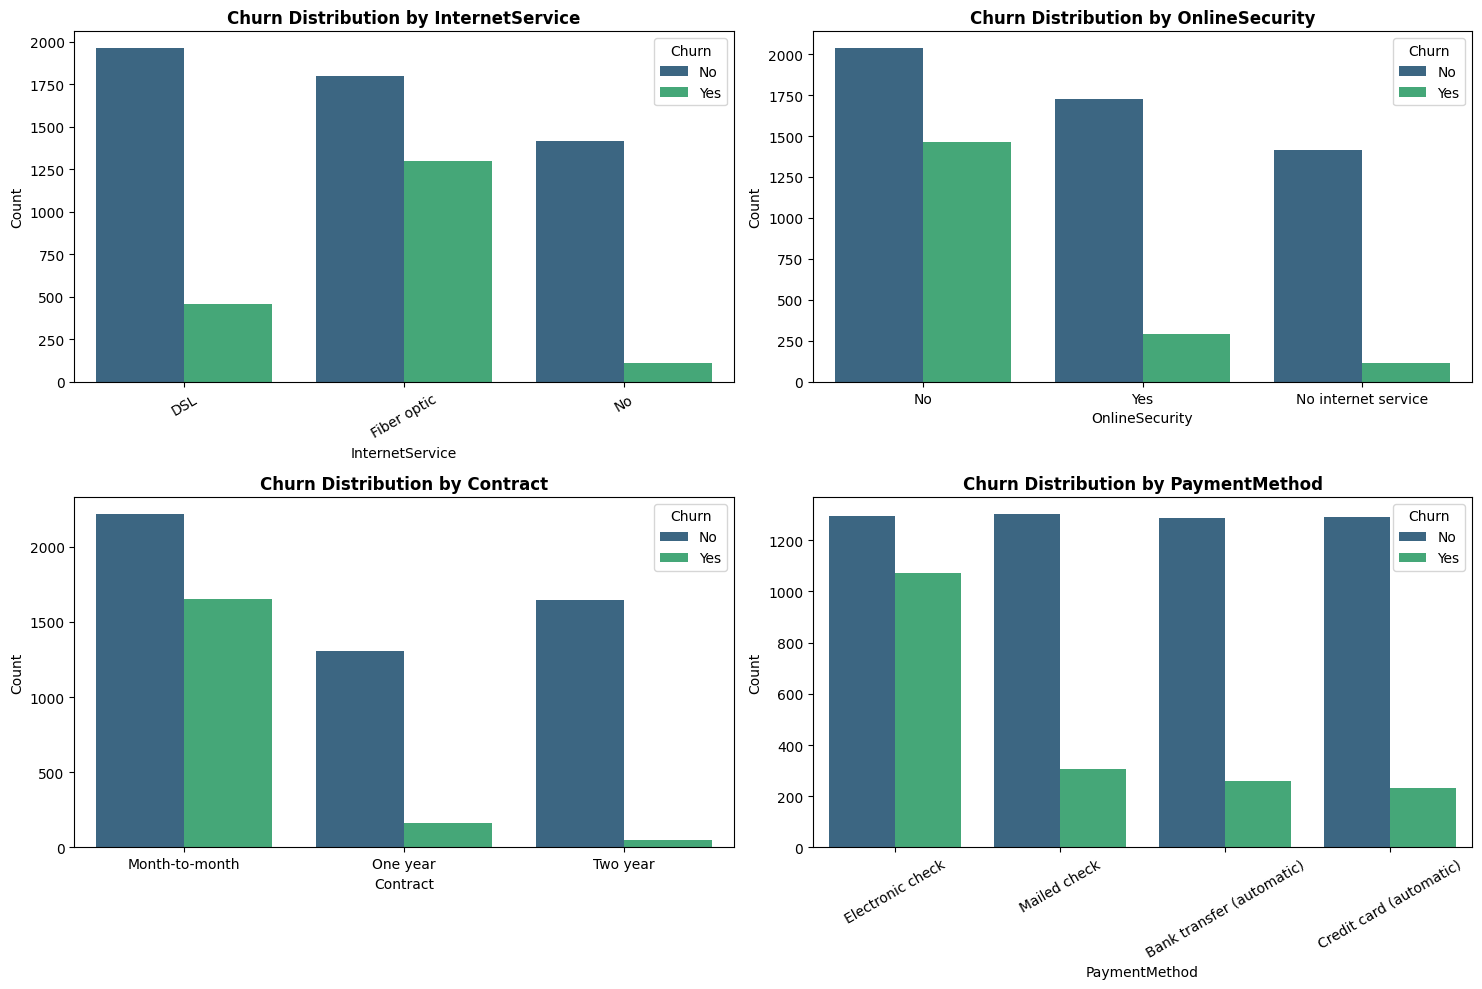

✅ EDA visualizations saved to images/


In [4]:
# ===== 1. Demographics Analysis =====
personal_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(personal_features):
    sns.countplot(data=data, x=feature, hue='Churn', ax=axes[i], palette='pastel')
    axes[i].set_title(f'Churn Distribution by {feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.savefig('images/demographics_churn.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== 2. Services & Contract Analysis =====
service_features = ['InternetService', 'OnlineSecurity', 'Contract', 'PaymentMethod']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(service_features):
    sns.countplot(data=data, x=feature, hue='Churn', ax=axes[i], palette='viridis')
    axes[i].set_title(f'Churn Distribution by {feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    if feature in ['PaymentMethod', 'InternetService']:
        axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('images/services_churn.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ EDA visualizations saved to images/")

## 5. Feature Engineering
Creating custom features based on business insights

In [5]:
# ===== Drop Irrelevant Features =====
cols_to_drop = ['customerID', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
data_clean = data.drop(columns=[c for c in cols_to_drop if c in data.columns])

# ===== Feature 1: Is_First_Year =====
# Based on EDA - first year has critical churn risk
data_clean['Is_First_Year'] = (data_clean['tenure'] <= 12).astype(int)

# ===== Feature 2: Services_Count =====
# Count of additional services (security, backup, protection, support)
security_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
data_clean['Services_Count'] = (data_clean[security_cols] == 'Yes').sum(axis=1)

# ===== One-Hot Encoding =====
data_final = pd.get_dummies(data_clean, drop_first=True)

print(f"✅ Feature Engineering complete")
print(f"📊 Total features for model: {len(data_final.columns)}")
print(f"📊 Custom features created: Is_First_Year, Services_Count")

✅ Feature Engineering complete
📊 Total features for model: 27
📊 Custom features created: Is_First_Year, Services_Count


## 6. Model Training & Evaluation

📊 Classification Report:
              precision    recall  f1-score   support

      Stayed       0.83      0.91      0.87      1036
     Churned       0.66      0.50      0.57       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



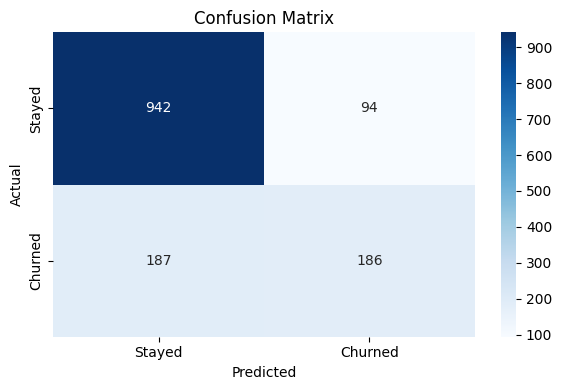

✅ Model trained and evaluated


In [6]:
# ===== Prepare Features and Target =====
X = data_final.drop('Churn_Yes', axis=1)
y = data_final['Churn_Yes']

# ===== Train-Test Split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== Train Random Forest Model =====
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# ===== Make Predictions =====
y_pred = rf_model.predict(X_test)
y_probs = rf_model.predict_proba(X_test)[:, 1]

# ===== Evaluate Model =====
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Stayed', 'Churned']))

# ===== Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stayed', 'Churned'],
            yticklabels=['Stayed', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('images/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Model trained and evaluated")

## 7. Feature Importance Analysis
Identifying key drivers of customer churn

📊 Top 15 Most Important Features:
                           Feature  Importance
3                     TotalCharges    0.192132
2                   MonthlyCharges    0.187439
1                           tenure    0.162050
10     InternetService_Fiber optic    0.043489
5                   Services_Count    0.037793
24  PaymentMethod_Electronic check    0.034349
4                    Is_First_Year    0.033843
6                      gender_Male    0.028409
21               Contract_Two year    0.026874
22            PaperlessBilling_Yes    0.025967
7                      Partner_Yes    0.025386
20               Contract_One year    0.021669
0                    SeniorCitizen    0.021030
8                   Dependents_Yes    0.019994
13              OnlineSecurity_Yes    0.019617


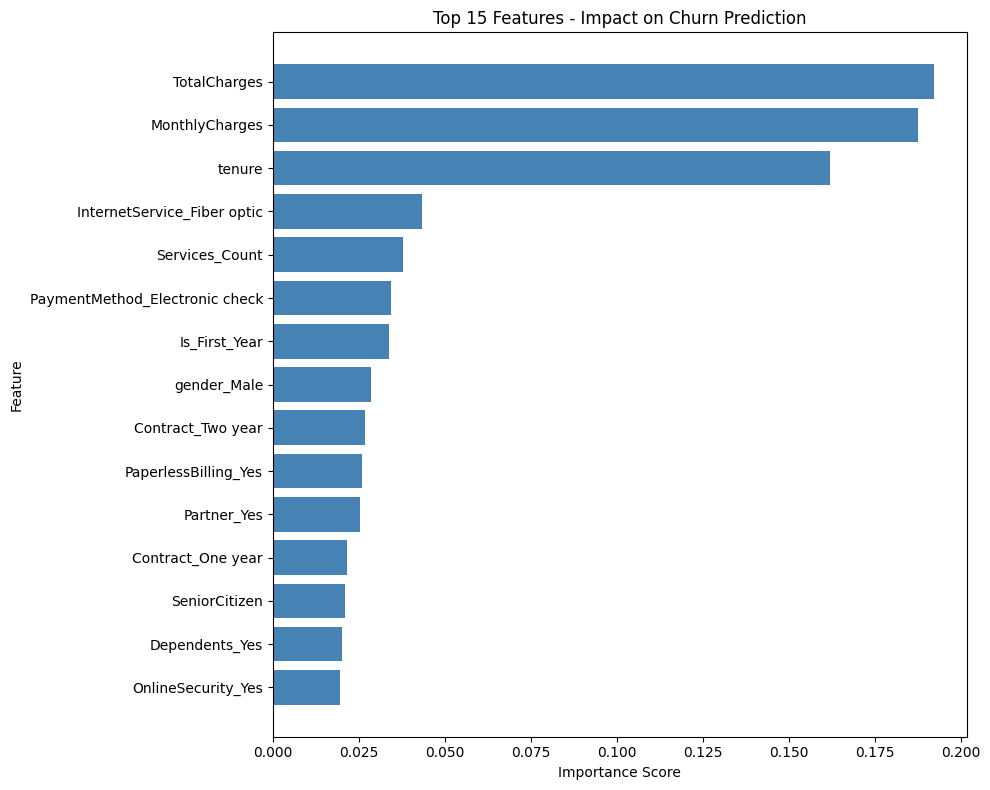

In [7]:
# ===== Extract Feature Importance =====
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("📊 Top 15 Most Important Features:")
print(feature_importance.head(15))

# ===== Visualize Top 15 Features =====
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(top_15['Feature'], top_15['Importance'], color='steelblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 15 Features - Impact on Churn Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('images/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Key Insight: TotalCharges, MonthlyCharges, and tenure are top 3 drivers

## 8. Advanced Visualizations
Tenure analysis, service engagement, and pricing patterns

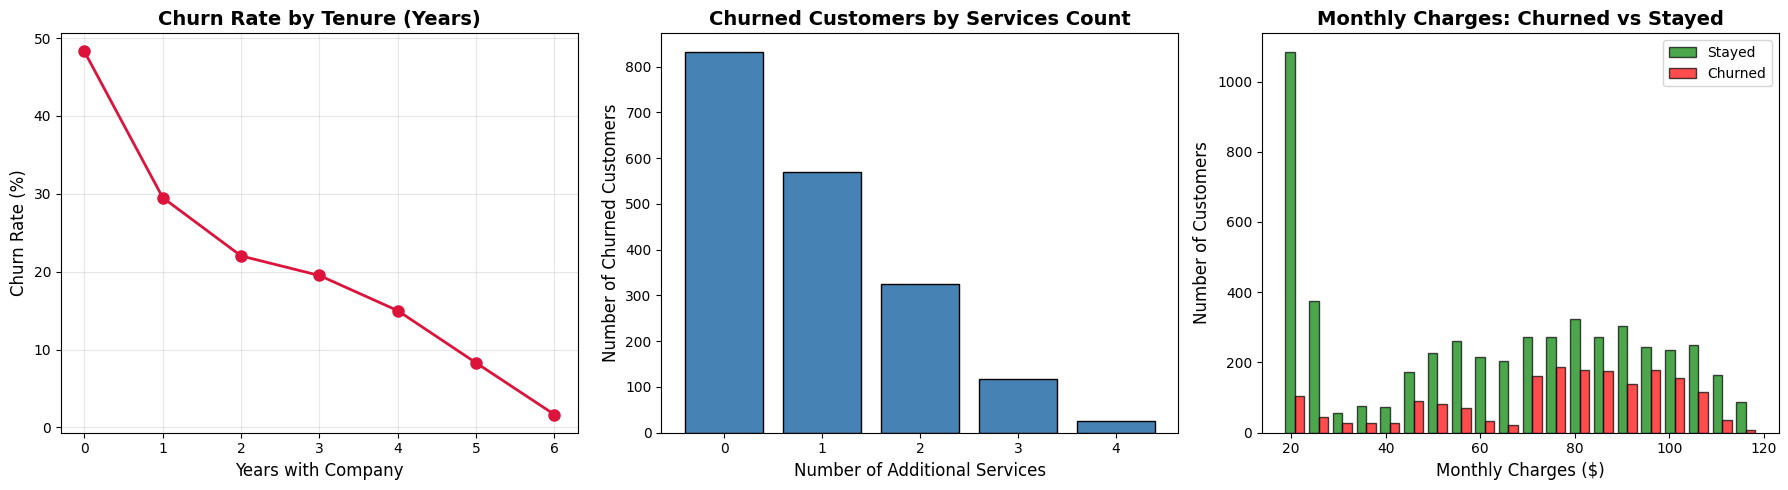


📊 Key Insights:
1. First year churn rate: 48.3%
2. Churned customers with 0 services: 831
3. Average Monthly Charge - Churned: $74.44
4. Average Monthly Charge - Stayed: $61.27


In [8]:
# ===== Create 3-Panel Visualization =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ===== Panel 1: Churn Rate by Tenure (Years) =====
tenure_bins = data_final['tenure'] // 12
churn_by_tenure = data_final.groupby(tenure_bins)['Churn_Yes'].mean() * 100

axes[0].plot(churn_by_tenure.index, churn_by_tenure.values,
             marker='o', linewidth=2, markersize=8, color='crimson')
axes[0].set_xlabel('Years with Company', fontsize=12)
axes[0].set_ylabel('Churn Rate (%)', fontsize=12)
axes[0].set_title('Churn Rate by Tenure (Years)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# ===== Panel 2: Churned Customers by Services Count =====
services_churn = data_final.groupby('Services_Count')['Churn_Yes'].sum()

axes[1].bar(services_churn.index, services_churn.values, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Number of Additional Services', fontsize=12)
axes[1].set_ylabel('Number of Churned Customers', fontsize=12)
axes[1].set_title('Churned Customers by Services Count', fontsize=14, fontweight='bold')
axes[1].set_xticks(services_churn.index)

# ===== Panel 3: Monthly Charges Distribution =====
churned = data_final[data_final['Churn_Yes'] == 1]['MonthlyCharges']
stayed = data_final[data_final['Churn_Yes'] == 0]['MonthlyCharges']

axes[2].hist([stayed, churned], bins=20, label=['Stayed', 'Churned'],
             color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Monthly Charges ($)', fontsize=12)
axes[2].set_ylabel('Number of Customers', fontsize=12)
axes[2].set_title('Monthly Charges: Churned vs Stayed', fontsize=14, fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.savefig('images/advanced_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== Print Key Insights =====
print("\n📊 Key Insights:")
print(f"1. First year churn rate: {churn_by_tenure.iloc[0]:.1f}%")
print(f"2. Churned customers with 0 services: {services_churn[0]}")
print(f"3. Average Monthly Charge - Churned: ${churned.mean():.2f}")
print(f"4. Average Monthly Charge - Stayed: ${stayed.mean():.2f}")

## 9. Business Intelligence - Risk Segmentation
Identifying highest-priority customers for retention campaigns

In [9]:
# ===== Create Unified Results DataFrame =====
results = X_test.copy()
results['Churn_Probability'] = y_probs
results['Actual_Churn'] = y_test

# ===== Top 10 Highest-Risk Customers =====
top_10_risk = results.sort_values(by='Churn_Probability', ascending=False).head(10)
columns_to_show = ['tenure', 'MonthlyCharges', 'Is_First_Year', 'Services_Count',
                    'Churn_Probability', 'Actual_Churn']

print("🚨 Top 10 Highest-Risk Customers:")
print(top_10_risk[columns_to_show])

# ===== Decile Analysis =====
results['Decile'] = pd.qcut(results['Churn_Probability'], 10, labels=False, duplicates='drop')

decile_analysis = results.groupby('Decile').agg({
    'Churn_Probability': ['min', 'max', 'mean'],
    'Actual_Churn': ['count', 'sum']
})

decile_analysis.columns = ['Min_Prob', 'Max_Prob', 'Avg_Prob', 'Total_Customers', 'Actual_Churners']
decile_analysis['Precision_Rate'] = decile_analysis['Actual_Churners'] / decile_analysis['Total_Customers']

print("\n📊 Decile Analysis (Risk Segmentation):")
print(decile_analysis.sort_index(ascending=False))

# Key Insight: Top decile (8-9) has 73% precision - these customers are highest priority
print(f"\n🎯 Top Decile Precision: {decile_analysis.loc[decile_analysis.index.max(), 'Precision_Rate']:.1%}")
print("✅ Analysis complete - ready for business recommendations")

🚨 Top 10 Highest-Risk Customers:
      tenure  MonthlyCharges  Is_First_Year  Services_Count  \
5640       1           79.60              1               0   
4800       1           94.00              1               0   
5782       1           69.65              1               0   
6933       1           69.60              1               0   
2191       1           91.30              1               0   
6168       1           79.25              1               0   
2184       2           88.55              1               1   
346        2           90.40              1               0   
585        1           85.70              1               0   
1371       1           79.20              1               0   

      Churn_Probability  Actual_Churn  
5640               1.00          True  
4800               1.00          True  
5782               1.00          True  
6933               1.00          True  
2191               1.00          True  
6168               0.99          